# Rethinking Parallel Coordinates Plots

This notebook is inspired [Ben Keen's blog post](https://benalexkeen.com/parallel-coordinates-in-matplotlib/) but it improves on his implementation in a couple of ways.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sns.set()

In [3]:
%matplotlib inline

## Load Data

In [4]:
df = pd.read_csv("data/datasets_309_669_Auto.csv")

In [5]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [6]:
df['horsepower'] = pd.to_numeric(df['horsepower'].replace('?', np.nan))

## Existing implementations

### Pandas parallel_coordinates

Pandas `parallel_coordinates` method requires a categorical "class_column" argument.

In [7]:
df['mpg_cat'] = pd.cut(df['mpg'], [8, 16, 24, 32, 50])

In [8]:
df.dtypes

mpg              float64
cylinders          int64
displacement     float64
horsepower       float64
weight             int64
acceleration     float64
year               int64
origin             int64
name              object
mpg_cat         category
dtype: object

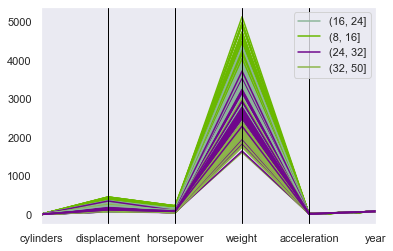

In [9]:
pd.plotting.parallel_coordinates(
    df[['mpg_cat', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']], 
    class_column='mpg_cat');

This style of plots is quite useless for visual analysis on most real-world data sets. To make a better chart, we need to normalize the data.

### Plotly interactive plots

Plotly has a [nice interactive implementation](https://plotly.com/python/parallel-coordinates-plot/) of parallel coordindate plots, however it has downsides in that it 1) requires Plotly, and 2) does not support some of the features we will implement here.

## Custom implementation

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm, colors, ticker
from scipy import stats
from pandas.api import types


def strip_prefix(x, s):
    return x[len(s):] if x.startswith(s) else x


def parallel_coordinates(df, dimensions=None, color=None, prefix=None, sort_ascending=True,
                         rank_color=False, log_scale=None, cmap="cividis", figsize=(15, 8), 
                         tick_length=6, ymargin=0.05, lw=2, alpha=1.0):
    """
    Based on https://stackoverflow.com/q/8230638/597371
    
    Example usage with Optuna `study' object:
    
    parallel_coordinates(study.trials_dataframe(), 
        dimensions=['num_leaves', 'n_estimators', 'max_depth', "learning_rate"], 
        color="value", prefix="params_")
        
    """
    
    if dimensions is None:
        columns = df.columns
        dimensions = columns if prefix is None \
            else [strip_prefix(c, prefix) for c in columns]
    else:
        columns = dimensions if prefix is None \
            else ["{}{}".format(prefix, d) for d in dimensions]

    if color is not None:
        if sort_ascending is not None:
            df = df.sort_values(by=color, ascending=sort_ascending)
        color = df[color]
        if rank_color:
            color = stats.rankdata(color)
    
    if log_scale is not None:
        if prefix is not None:
            log_scale = ["{}{}".format(prefix, col) for col in log_scale]
    else:
        log_scale = []
    
    data = df[columns]
    n_dims = len(dimensions)
    is_log_scale = [(col in log_scale) for col in data.columns]
    is_integer = [types.is_integer_dtype(data[col]) for col in data.columns]
    tick_formats = [('%d' if (is_integer[i] and not is_log_scale[i]) else '%4.2f') for i in range(n_dims)]
    tick_nbins = [(9 if is_integer[i] else 5) for i in range(n_dims)]
    
    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(1, n_dims - 1, figure=fig)
    grid.update(wspace=0., hspace=0.)
    axes = [plt.subplot(gs) for gs in grid]

    # Optional log scaling
    if log_scale:
        data = pd.DataFrame({
            col: (np.log10(data[col]) if col in log_scale else data[col])
            for col in columns 
        })
    
    # Calculate scaling table
    yscales = []
    for col in columns:
        ds = data[col]
        ymin, ymax = ds.min(), ds.max()
        if ymin == ymax:
            ymin -= 0.5
            ymax = y_min + 1.
        yrange = float(ymax - ymin)
        yscales.append((ymin, yrange))

    # Normalize data
    data = pd.DataFrame({
        col: (data[col] - ymin) / yrange 
        for col, (ymin, yrange) in zip(columns, yscales)
    })

    # Generate colors from color map
    if color is None:
        rgba_colors = ["C0"] * len(data)
    else:
        if isinstance(cmap, str):
            cmap = getattr(cm, cmap)
        cnorm = colors.Normalize(vmin=color.min(), vmax=color.max())
        rgba_colors = cmap(cnorm(color).filled(np.nan), bytes=False)
    
    # Plot data
    data_values = data.values
    for dim, ax in enumerate(axes):
        xs = [dim, dim + 1]
        for rgba_color, row in zip(rgba_colors, data_values[:, xs]):
            ax.plot(xs, row, color=rgba_color, lw=lw, alpha=alpha)
    
    # Format axes
    for dim, ax in enumerate(axes):
        
        ymin, yrange = yscales[dim]
        ylocator = ticker.MaxNLocator(nbins=tick_nbins[dim], integer=is_integer[dim])
        ylower, yupper = ymin, ymin + yrange
        ylabels = ylocator.tick_values(ylower, yupper)
        yloci = [(y - ymin) / yrange for y in ylabels]
        yloci, ylabels = zip(*[(y, lbl) for y, lbl in 
                               zip(yloci, ylabels) if -0.025 <= y <= 1.025])
        ax.set_yticks(yloci)
        ax.set_yticklabels([tick_formats[dim] % y for y in ylabels])
        
        ax.set_xlim(dim, dim + 1)
        ax.set_ylim(0. - ymargin, 1. + ymargin)
        xlocator = ticker.FixedLocator([dim])
        ax.xaxis.set_major_locator(xlocator)

        ax.set_xticklabels([dimensions[dim]])
        ax.tick_params(top=False, bottom=False, left=True, right=False, 
                       labelleft=True, labelright=False, length=tick_length)
        ax.grid(False)
    
    # Draw last axis on the right-hand side
    ax = axes[-1].twinx()
    dim = n_dims - 1
    
    ymin, yrange = yscales[dim]
    ylocator = ticker.MaxNLocator(nbins=tick_nbins[dim], integer=is_integer[dim])
    ylower, yupper = ymin, ymin + yrange
    ylabels = ylocator.tick_values(ylower, yupper)
    yloci = [(y - ymin) / yrange for y in ylabels]
    yloci, ylabels = zip(*[(y, lbl) for y, lbl in 
                           zip(yloci, ylabels) if -0.025 <= y <= 1.025])
    ax.set_yticks(yloci)
    ax.set_yticklabels([tick_formats[dim] % y for y in ylabels])

    ax.set_ylim(0. - ymargin, 1. + ymargin)
    xlocator = ticker.FixedLocator([n_dims - 2, n_dims - 1])
    ax.xaxis.set_major_locator(xlocator)
    
    ax.set_xticklabels([dimensions[dim - 1], dimensions[dim]])
    ax.tick_params(top=False, bottom=False, left=False, right=True, 
                   labelleft=False, labelright=True, length=tick_length)
    ax.grid(False)

### Unsorted data

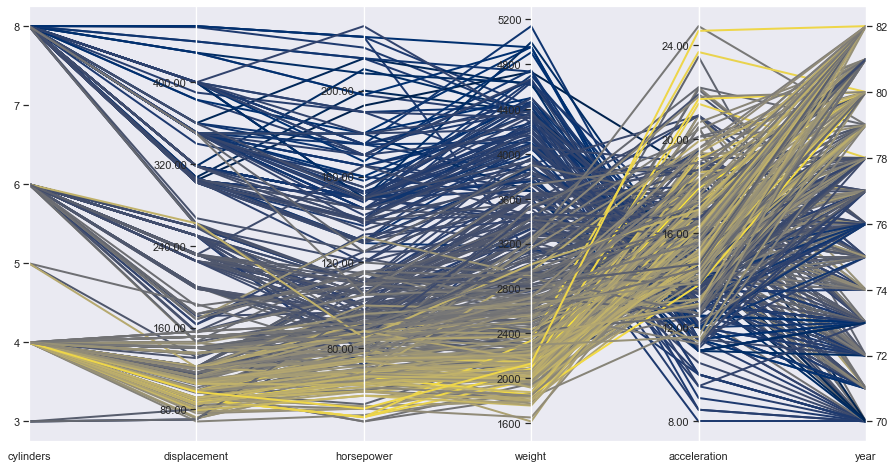

In [11]:
parallel_coordinates(df, color="mpg", sort_ascending=None,
                     dimensions=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'])

### Ranked color

Converting color column (miles per gallon) to ranks suppresses influence of outliers and makes for a more clear plot.

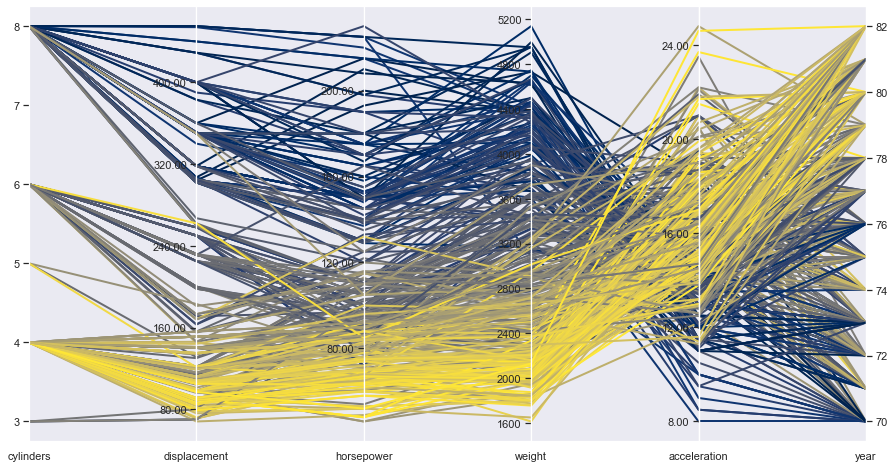

In [12]:
parallel_coordinates(df, color="mpg", sort_ascending=None, rank_color=True,
                     dimensions=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'])

### Ranked and sorted

Even more clarity is achieved by sorting the dataframe by `mpg` column so that glyphs corresponding to high mileage cares are plotted on top.

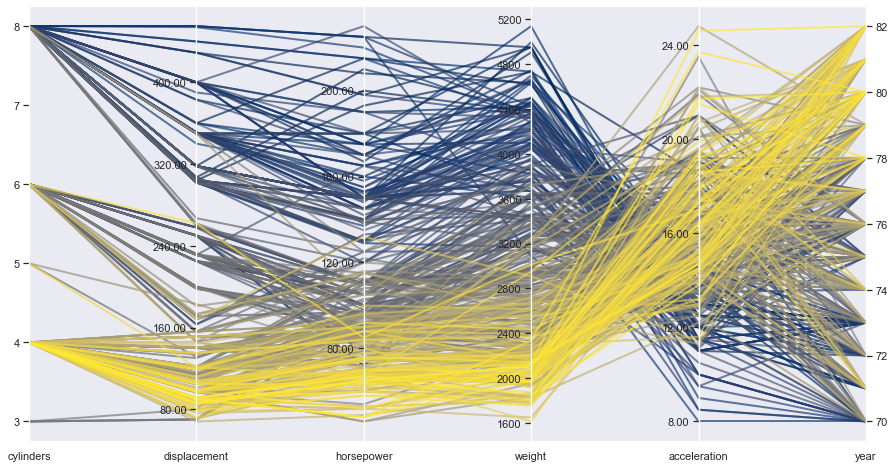

In [13]:
parallel_coordinates(df, color="mpg", sort_ascending=True, rank_color=True, alpha=0.66,
                     dimensions=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'])

The chart makes it immediately clear that high mileage cars have low weight, horse power, displacement, and typically four cyllinders. They also tend to have higher acceleration (probably a function of lower weight) and they started being released in late 1970s.

We can also discern that weight appears to be the strongest factor influencing gas consumption. Some of it, of course, is due to there being two types of cars: heavy and light. However we can still consider weight as a "causal" factor: although horsepower and related factors are also important, the primary reason certain vehicles are being made with high horsepower engines is because they are designed to be heavy.

# Main take-aways

Parallel coordinates plots are a neat and underused tool. This is partly due to lack of good implementations, but also partly due to lack of clear examples that demonstrate their benefits. The few existing libraries focus on interactivity while somewhat disregarding visual presentation. While interactive plots are nice, they do not substitute for clear visual presentation; interactivity is more of a charry on top---one needs to have a cake to begin with!